# Lab 4

Integrantes:
- Francis Aguilar, 
- César López, 
- Jose Marchena, 22398

Repo:
https://github.com/MarchMol/lab4_vision

## Task 1
El objetivo es evlauar la compresió de la geometría proyectiva y la manipulación alegbraica de coordenadas homogéneas. Entonces, responda la siguientes preguntas demostrando el desarrollo matemático. No se aceptan respuestas puramente textuales sin respaldo alegraico.

**1. Una homografía 𝐻 es una matriz de 3 × 3. Explique matemáticamente por qué, aunque tiene 9 elementos, solo posee 8 grados de libertad (GDL)**

**R//**
Esto es por el valor de escala que se le agrega a las cordenadas al convertirlas de espacio euclideano a homogeneo.
Matematicamente, está la equivalencia de x ~ kx que nos indica que este valor de escala no afecta/no se toma en cuenta en el caso de proyecciones 3d lo que nos elimina el grado de libertad, o restricciones que implica tomar en cuenta este valor en los calculos


**a. Adicionalmente, respoda. Si tuviéramos una cámara que solo rota sobre su eje óptico (sin traslación ni cambio de perspectiva), ¿la matriz de transformación sigue teniendo 8 GDL o se reduce? Demuestre la estructura de dicha matriz simplificada**


**R//**

Si en lugar de tomar en cuenta 3 posibles direcciones a cuales rotar, tomamos solo 1 posible movimiento de rotacion correspondiente al angulo sobre el eje optico, reducimos 3 GLD -> 1 GLD.
Asimismo, si eliminamos tambien traslacion por completo reducimos 3 GDL (correspondiente a las coordenadas x,y,z) a 0, pues no los debemos tomar en cuenta. Lo mismo aplica al cambio de perspectiva, si no aplica a nuestro caso no contamos los GLD

Por tanto pasamos de 3 GLD de rotacion, 3 de traslacion y 3 de perspectiva (9 valores en H) a 1 GLD correspondiente a la rotacion en el eje optico.

La matriz se veria asi, la cual es la matriz 3D estandar para para definir rotaciones en espacio normalizado
$$
M=\begin{bmatrix}
cos(θ) & -sin(θ) & 0\\
sin(θ) & cos(θ) & 0\\
0 & 0 & 1
\end{bmatrix}
$$



**2. En el algoritmo DLT (Direct Linear Transform), convertimos el problema 𝑥′ = 𝐻𝑥 en un sistema de la forma 𝐴ℎ = 0. Explique por qué buscamos el vector singular asociado al menor valor singular de 𝐴 en lugar de simplemente invertir la matriz. ¿Qué representa geométricamente ese "menor valor singular" cuando los datos tienen ruido?**

**R//**
la idea de invertir la matriz A no aplica a nuestro caso porque es una ecuacion homogenea. Es decir, estamos igualando a 0 por tanto no hay nada que invertir del otro lado de la ecuacion, especialmente, porque estamos buscando soluciones no triviales. Tambien hay otros problemas al pensar en sacar la inversa de la matriz, por ejemplo, A no siempre sera cuadrada.

Por ultimo, el menor valor singular de A, geometricamente, nos indica la direccion del espacio nulo, es decir, donde todos los valores se hacen 0, pero en la realidad, el ruido hace que no podamos solucionar por completo una transformacion. No buscamos realmente Ah = 0 porque el ruido va a hacer que nunca sea 0, sino que tratamos de MINIMIZAR Ah dada la restriccion de que la magnitud de h es 1. Por tanto aproximamos la solucion con SVD.


3. Si usted selecciona 4 puntos para calcular 𝐻, pero 3 de ellos son colineales (están en la misma línea recta), el algoritmo fallará. Explique algebraicamente qué le sucede a la matriz 𝐴 del sistema DLT en este caso y por qué no tiene solución única.

Cada punto en la transformacion de homografia corresponde a 2 ecuaciones que se solucionan. Si 3 de estos puntos son colineares, o equivalentes, esto resulta en realmente 2 puntos "unicos".
Si lo miramos desde la perspectiva de grados de libertad, las ecuaciones unicas tienen que minimo corresponder a los grados de libertad, por eso es que se necesitan >= 4 puntos no colineares; porque si no no cumplen las restricciones minimas para hacer una proyeccion apropiada.

Asimismo, algebraicamente lo que le ocurre a A es que se vuelve inestable, pues hay muchas soluciones que corresponden a Ah = 0 y no se asegura que encontremos una ni que sea correcta. Pequeñas variaciones en ruido pueden cambiar el resultado completo de la homografia.

## Task 2

El objetivo de esta parte es implementar el pipeline de alineación sin depender de cajas negras. Por ello
considere que no deben de usar cv2.findHonography o cv2.RANSAC. Además para este laboratorio
necesitara crear su propio dataset, por ello tome 3 fotografías propias de una escena planar (i.e. una
pancarta en una pared, un cuadro, o una fachada de edificio lejana) con ángulos y perspectivas
drásticamente diferentes. Con esto realice:
1. Detección y Macheo
    a. Utilice SIFT u ORB (permitido usar OpenCV aquí) para detectar puntos de interés y descriptores.
    
    b. Realice un emparejamiento de fuerza bruta (Brute-Force Matcher).
    
    c. Requisito: Visualice los matches antes de filtrar. Debe verse una cantidad considerable de ruido/errores.

2. Algoritmo DLT
    a. Escriba una función calcular_homografia_dlt(puntos_src, puntos_dst) que reciba exactamente 4 pares de puntos.

    b. Debe construir la matriz A de tamaño 8×9.

    c. Debe resolver el sistema usando SVD (numpy.linalg.svd).

    d. Nota: Debe normalizar los puntos antes de entrar al DLT (restar la media y dividir por la desviación estándar) para estabilidad numérica, y des-normalizar la matriz H resultante.

3. RANSAC Manual
    a. Implemente la función ransac_homografia(matches, umbral, prob_exito).

    b. Cálculo de N: Su código debe calcular dinámicamente el número de iteraciones N basado en la fórmula de probabilidad vista en clase. No "hardcodee" el número 1000.

    c. Bucle:
        i. Seleccione 4 matches aleatorios.
        ii. Llame a su función DLT.
        iii. Proyecte todos los puntos fuente usando H_test.
        iv. Calcule el error de reproyección (distancia Euclidiana) y cuente los inliers.

    d. Refinamiento: Una vez encontrado el mejor conjunto de inliers, recalcule 𝐻 final usando todos los inliers (no solo los 4 iniciales) mediante SVD La salida esperada es una imagen “stitched” (panorama) mostrando la alineación correcta.

Keypoints imagen 1: 2043
Keypoints imagen 2: 3361
Cantidad total de matches: 2043


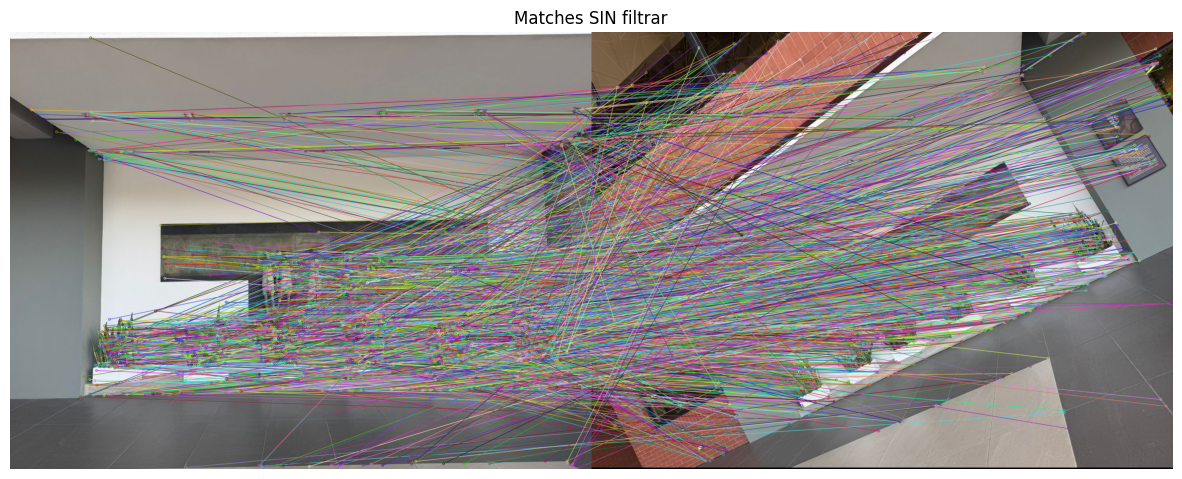

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread("./db/img1.jpeg")
img2 = cv2.imread("./db/img2.jpeg")

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detectar puntos con SIFT
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print("Keypoints imagen 1:", len(kp1))
print("Keypoints imagen 2:", len(kp2))

# Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

matches = bf.match(des1, des2)

print("Cantidad total de matches:", len(matches))


# Visualización SIN FILTRAR
img_matches = cv2.drawMatches(
    img1, kp1,
    img2, kp2,
    matches,  
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Matches SIN filtrar")
plt.axis("off")
plt.show()


SIFT Matching
Matches totales: 2043
Good matches: 193


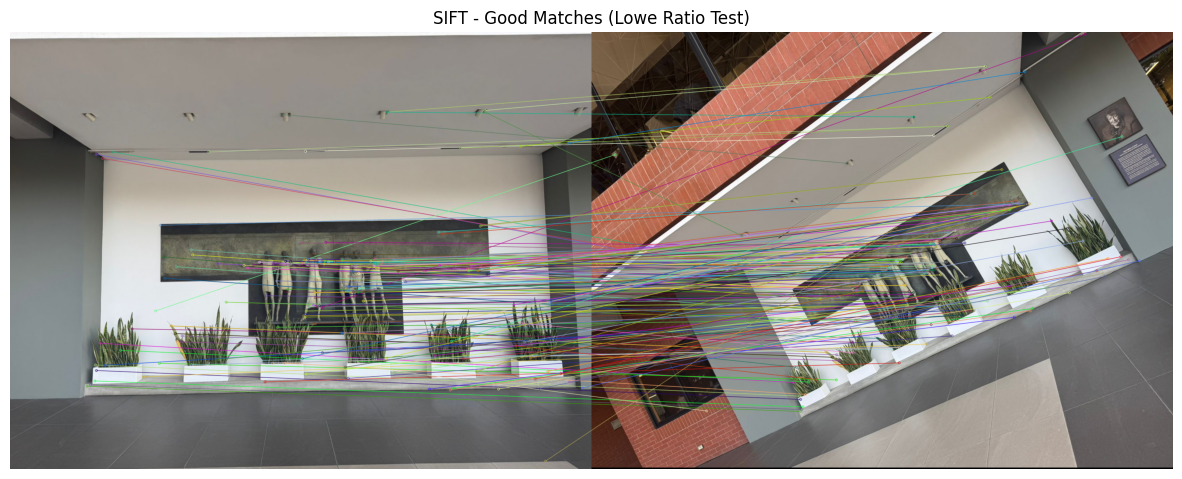

In [26]:
# KNN matching (k=2 para Lowe)
matches_sift = bf.knnMatch(des1, des2, k=2)

good_matches_sift = []
ratio_thresh = 0.75

for m, n in matches_sift:
    if m.distance < ratio_thresh * n.distance:
        good_matches_sift.append(m)

print("SIFT Matching")
print("Matches totales:", len(matches_sift))
print("Good matches:", len(good_matches_sift))

img_matches_sift = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    good_matches_sift,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)


plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(img_matches_sift, cv2.COLOR_BGR2RGB))
plt.title("SIFT - Good Matches (Lowe Ratio Test)")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np

def normalizar_puntos(puntos):

    puntos = np.array(puntos)
    
    media = np.mean(puntos, axis=0)
    std = np.std(puntos, axis=0)

    std[std == 0] = 1e-8

    T = np.array([
        [1/std[0], 0, -media[0]/std[0]],
        [0, 1/std[1], -media[1]/std[1]],
        [0, 0, 1]
    ])

    # Convertir a homogéneos
    puntos_h = np.hstack((puntos, np.ones((puntos.shape[0], 1))))

    # Aplicar normalización
    puntos_norm_h = (T @ puntos_h.T).T

    return puntos_norm_h[:, :2], T


def calcular_homografia_dlt(puntos_src, puntos_dst):
    
    # Normalización
    src_norm, T_src = normalizar_puntos(puntos_src)
    dst_norm, T_dst = normalizar_puntos(puntos_dst)

    # Construcción matriz A (8x9)
    A = []

    for i in range(4):
        x, y = src_norm[i]
        xp, yp = dst_norm[i]

        fila1 = [-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp]
        fila2 = [0, 0, 0, -x, -y, -1, x*yp, y*yp, yp]

        A.append(fila1)
        A.append(fila2)

    A = np.array(A)

    # Verificación tamaño
    assert A.shape == (8, 9), "La matriz A no es 8x9"

    # Resolver usando SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]

    H_norm = h.reshape(3, 3)
    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    H = H / H[2, 2]

    return H


In [28]:
puntos_src = [
    [100, 200],
    [200, 200],
    [200, 300],
    [100, 300]
]

puntos_dst = [
    [120, 220],
    [230, 210],
    [220, 320],
    [110, 330]
]

H = calcular_homografia_dlt(puntos_src, puntos_dst)

print("Homografía estimada:")
print(H)


Homografía estimada:
[[ 1.10000000e+00 -1.00000000e-01  3.00000000e+01]
 [-1.00000000e-01  1.10000000e+00  1.00000000e+01]
 [ 4.50186578e-18  5.46334713e-18  1.00000000e+00]]


In [ ]:
def reproyectar_puntos(H, puntos):
    puntos = np.array(puntos)
    puntos_h = np.hstack((puntos, np.ones((puntos.shape[0], 1))))

    puntos_proj_h = (H @ puntos_h.T).T
    puntos_proj_h /= puntos_proj_h[:, 2][:, np.newaxis]

    return puntos_proj_h[:, :2]


In [ ]:
import numpy as np
import random

def ransac_homografia(matches, kp1, kp2, umbral=3.0, prob_exito=0.99):

    s = 4  # mínimo para homografía
    total_matches = len(matches)

    mejor_H = None
    mejor_inliers = []
    mejor_ratio_inliers = 0

    # Estimación inicial conservadora
    w = 0.5
    N = int(np.log(1 - prob_exito) / np.log(1 - w**s))
    N = max(N, 1)

    iteracion = 0

    while iteracion < N:

        muestra = random.sample(matches, 4)

        puntos_src = []
        puntos_dst = []

        for m in muestra:
            puntos_src.append(kp1[m.queryIdx].pt)
            puntos_dst.append(kp2[m.trainIdx].pt)

        try:
            H_test = calcular_homografia_dlt(puntos_src, puntos_dst)
        except:
            iteracion += 1
            continue

        src_all = np.array([kp1[m.queryIdx].pt for m in matches])
        dst_all = np.array([kp2[m.trainIdx].pt for m in matches])

        proyectados = reproyectar_puntos(H_test, src_all)

        errores = np.linalg.norm(proyectados - dst_all, axis=1)

        inliers = [matches[i] for i in range(len(matches)) if errores[i] < umbral]

        ratio_inliers = len(inliers) / total_matches

        if ratio_inliers > mejor_ratio_inliers:
            mejor_ratio_inliers = ratio_inliers
            mejor_H = H_test
            mejor_inliers = inliers

            # Actualizar w y recalcular N dinámicamente
            w = ratio_inliers
            if w > 0:
                N = int(np.log(1 - prob_exito) / np.log(1 - w**s))
                N = min(N, 5000)  # evitar explosión

        iteracion += 1

    print("Iteraciones ejecutadas:", iteracion)
    print("Mejor ratio de inliers:", mejor_ratio_inliers)
    print("Cantidad de inliers:", len(mejor_inliers))

    if len(mejor_inliers) >= 4:

        puntos_src_in = [kp1[m.queryIdx].pt for m in mejor_inliers]
        puntos_dst_in = [kp2[m.trainIdx].pt for m in mejor_inliers]

        H_final = calcular_homografia_dlt_general(puntos_src_in, puntos_dst_in)

    else:
        H_final = mejor_H

    return H_final, mejor_inliers


In [ ]:
def calcular_homografia_dlt_general(puntos_src, puntos_dst):
 

    src_norm, T_src = normalizar_puntos(puntos_src)
    dst_norm, T_dst = normalizar_puntos(puntos_dst)

    A = []

    for i in range(len(src_norm)):
        x, y = src_norm[i]
        xp, yp = dst_norm[i]

        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    H_norm = Vt[-1].reshape(3,3)

    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    H = H / H[2,2]

    return H


In [ ]:
def warp_manual(img_src, H, output_shape, offset):

    h_out, w_out = output_shape
    resultado = np.zeros((h_out, w_out, 3), dtype=np.uint8)

    H_inv = np.linalg.inv(H)

    for y in range(h_out):
        for x in range(w_out):

            # Coordenadas reales considerando offset
            x_real = x - offset[0]
            y_real = y - offset[1]

            punto_dst = np.array([x_real, y_real, 1])
            punto_src = H_inv @ punto_dst
            punto_src /= punto_src[2]

            xs, ys = punto_src[0], punto_src[1]

            if 0 <= xs < img_src.shape[1] and 0 <= ys < img_src.shape[0]:
                resultado[y, x] = img_src[int(ys), int(xs)]

    return resultado


In [ ]:
def crear_panorama(img1, img2, H):
 
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Esquinas imagen 1
    esquinas_img1 = np.array([
        [0, 0],
        [w1, 0],
        [w1, h1],
        [0, h1]
    ])

    # Proyectar esquinas
    esquinas_proj = reproyectar_puntos(H, esquinas_img1)

    # Esquinas imagen 2
    esquinas_img2 = np.array([
        [0, 0],
        [w2, 0],
        [w2, h2],
        [0, h2]
    ])

    todas = np.vstack((esquinas_proj, esquinas_img2))

    xmin, ymin = np.floor(todas.min(axis=0)).astype(int)
    xmax, ymax = np.ceil(todas.max(axis=0)).astype(int)

    ancho = xmax - xmin
    alto = ymax - ymin

    offset_x = -xmin
    offset_y = -ymin

    # Warp imagen 1
    panorama = warp_manual(
        img1,
        H,
        (alto, ancho),
        (offset_x, offset_y)
    )

    # Copiar imagen 2 directamente
    panorama[offset_y:offset_y+h2, offset_x:offset_x+w2] = img2

    return panorama


C:\Users\Francis\AppData\Local\Temp\ipykernel_34596\1948225608.py:11: RuntimeWarning: divide by zero encountered in divide
  puntos_proj_h /= puntos_proj_h[:, 2][:, np.newaxis]
C:\Users\Francis\AppData\Local\Temp\ipykernel_34596\1948225608.py:11: RuntimeWarning: invalid value encountered in divide
  puntos_proj_h /= puntos_proj_h[:, 2][:, np.newaxis]


Iteraciones ejecutadas: 5000
Mejor ratio de inliers: 0.034752814488497305
Cantidad de inliers: 71


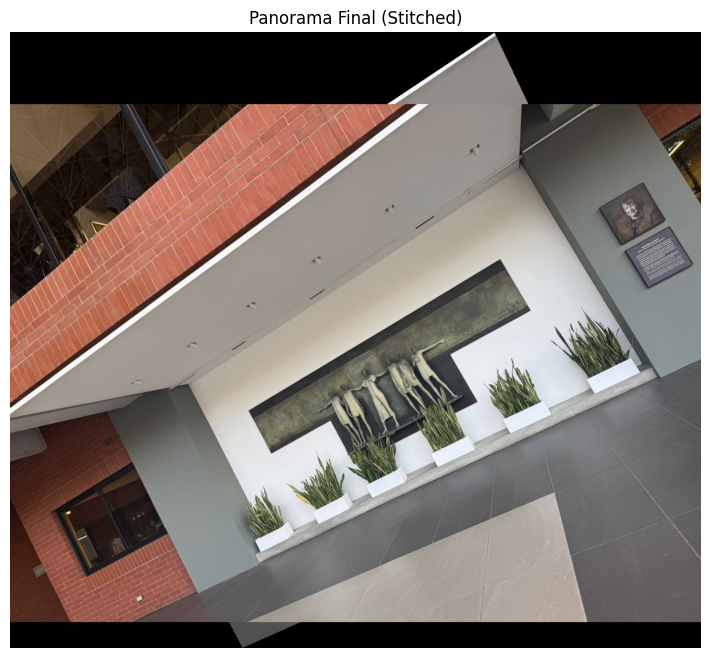

In [36]:
# 1. Detectar features
# 2. Matching
# 3. Ejecutar RANSAC manual

H_final, inliers = ransac_homografia(matches, kp1, kp2)

# 4. Crear panorama
panorama = crear_panorama(img1, img2, H_final)

# 5. Mostrar resultado
plt.figure(figsize=(15,8))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Panorama Final (Stitched)")
plt.axis("off")
plt.show()


## Task 3
En esta parte lo que se busca es evaluar el criterio profesional ante situaciones adversas y trade-offs de
diseño. Para ello realice y responda lo siguiente
1. Ejecute su algoritmo RANSAC variando el parámetro de umbral de error (threshold) en pixeles (ej. 1px, 5px, 20px)

    a. Genere una gráfica: Eje X = Umbral, Eje Y = Número de Inliers encontrados.

    b. Discusión: Como ingeniero, ¿qué riesgo corre si establece un umbral demasiado estricto (ej. 0.5px)? ¿Qué pasa con la matriz final si el umbral es muy laxo (ej. 50px)?

2. Imagine que usted es el Lead Computer Vision Engineer de una empresa de drones. Deben alinear imágenes térmicas de paneles solares tomadas desde el aire para detectar fallos.

    a. Problema: El drone vuela a 50 metros de altura. El terreno no es perfectamente plano (hay colinas suaves), pero los paneles sí son planos.

    b. Pregunta A: ¿Es válido usar una Homografía global para unir todo el mapa del terreno? ¿Por qué sí o por qué no?

    c. Pregunta B: Su algoritmo RANSAC está tardando demasiado (3 segundos por frame) en la computadora a bordo del drone (Raspberry Pi). La telemetría indica que el 90% de los matches iniciales son outliers debido al pasto y árboles repetitivos.

      i. Proponga una estrategia concreta para reducir el tiempo de ejecución sin cambiar el hardware. (Pista: Piense en la fórmula de N o en pre-filtrado geométrico)